# Parallax Tutorial 02

This is the second tutorial notebook in the parallax series.  
In this tutorial notebook we will cover:
- Subpixel upsampling
- Aberration fitting and correction

### Downloads
This tutorial uses the following datasets:
- [parallax_apoferritin_simulation.h5](https://drive.google.com/file/d/1hr-fhseEr5XnWWVc4V6gNKXNYQwAoPez/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2024 May 6

In [1]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

0.14.14


### Cross-Correlation Alignment

First, we load the infinite-dose dataset, add Poisson noise equal to 50e/Å$^2$, and reconstruct as in the previous tutorial.

In [2]:
file_path = 'data/'
file_data = file_path + 'parallax_apoferritin_simulation.h5'

dataset = py4DSTEM.read(file_data)

np.random.seed(1234)
area_per_probe = dataset.calibration.get_R_pixel_size()**2
dataset.data = np.random.poisson((dataset.data * 50 * area_per_probe).clip(0)).astype(np.uint64)

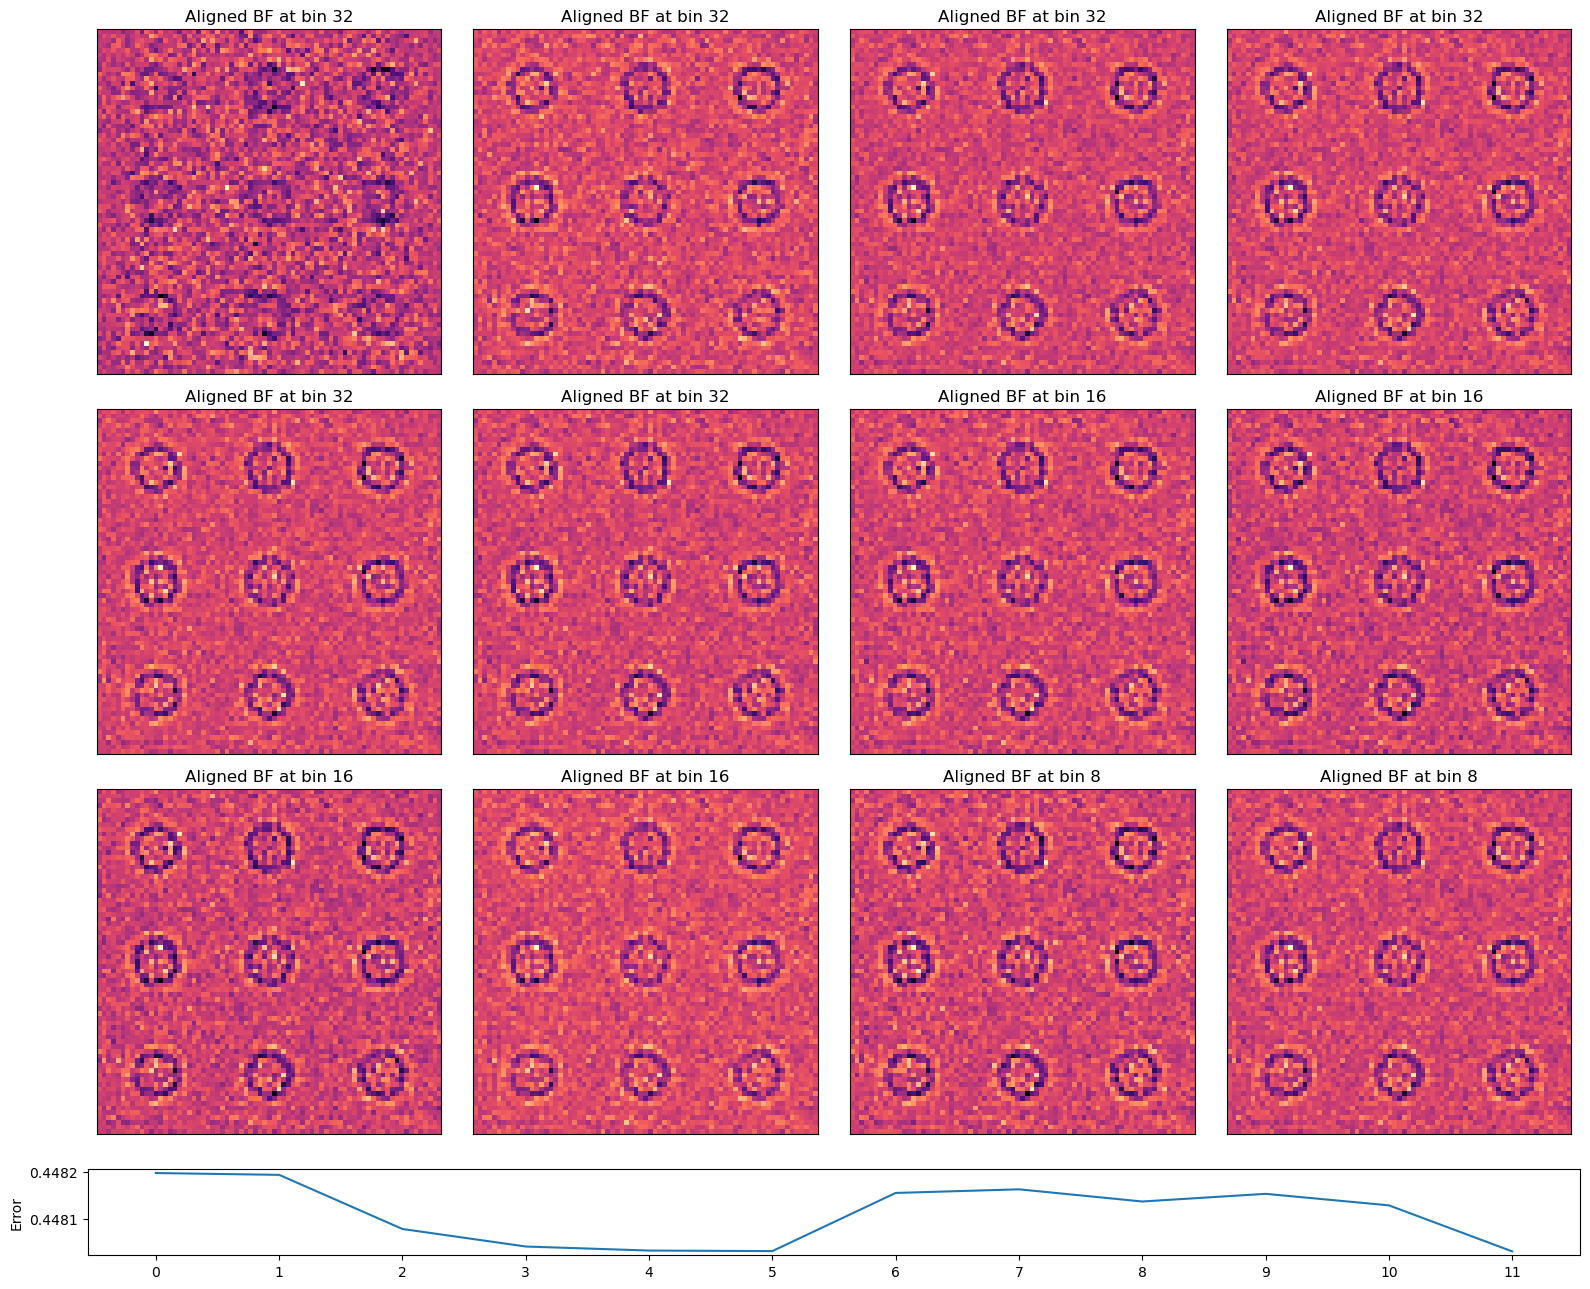

In [3]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,32,32,32,32,16,16,16,16,8,8],
    regularize_shifts=False,
    progress_bar=False,
)

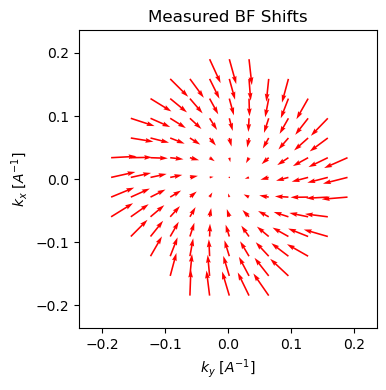

In [4]:
parallax.show_shifts(
    plot_arrow_freq=4, # plot every 4th arrow for clarity
)

### Subpixel Upsampling
The cross-correlation shifts have subpixel accuracy, so we can use them to improve the real-space sampling of our reconstructed image.

Here, we use kernel-density estimation to improve the real-space sampling (and thus the information limit) of our reconstruction.

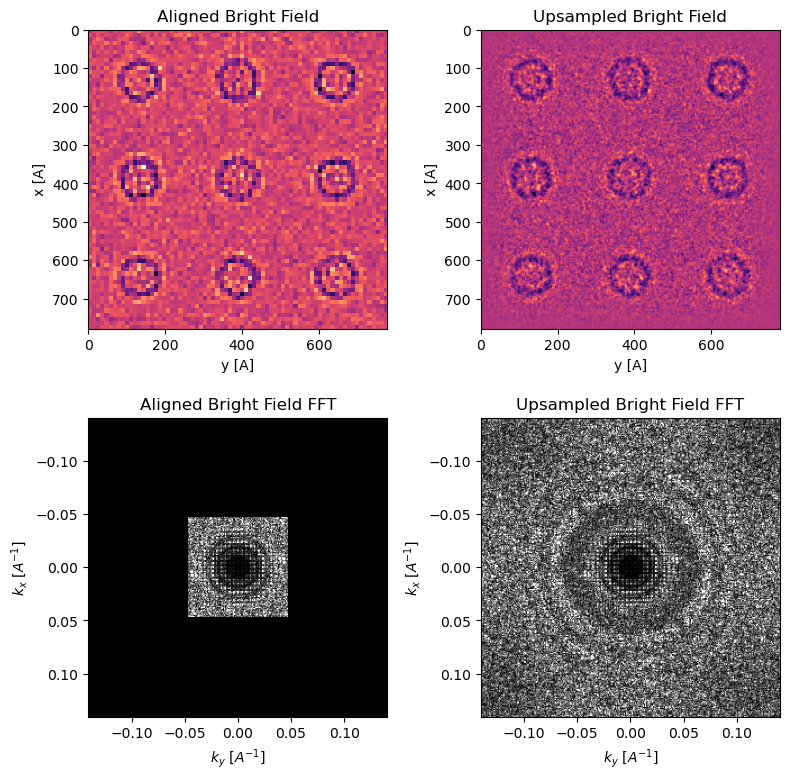

In [5]:
parallax = parallax.subpixel_alignment(
    kde_upsample_factor=3,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

It might be slightly hard to see due to the low dose used, but there's additional Thon ring oscillations past the initial 0.05 k Å$^1$ Nyquist limit of the scan sampling.  
Here we perfom an angular average to illustrate these Fourier intensity modulations:

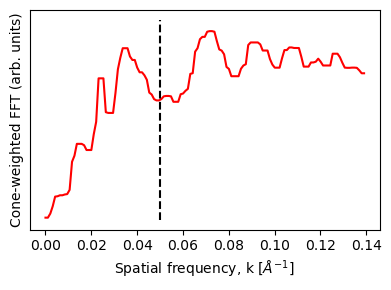

In [6]:
from scipy.ndimage import median_filter

def cone_weighted_fft(array, sampling):
    nx, ny = array.shape
    kx = np.fft.fftfreq(nx, d=sampling)
    ky = np.fft.fftfreq(ny, d=sampling)
    k = np.sqrt(kx[:, None] ** 2 + ky[None, :] ** 2)
    return np.abs(np.fft.fft2(array))*k, k

def cone_weighted_radial_fft(array, sampling, median_filter_radius):
    fft, k = cone_weighted_fft(array,sampling)
    radial_fft = py4DSTEM.process.phase.utils.cartesian_to_polar_transform_2Ddata(
        fft,
        xy_center=(0,0),
        corner_centered=True
    )
    radial_fft_filtered = median_filter(radial_fft.sum(0),median_filter_radius)
    return k[:radial_fft_filtered.shape[0],0], radial_fft_filtered

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(
    *cone_weighted_radial_fft(
        parallax.recon_BF_subpixel_aligned,
        parallax._scan_sampling[0] / parallax._kde_upsample_factor,
        5
    ),
    color='red'
)

ax.vlines(0.05,0,50,linestyles='dashed',colors='black')
ax.set_yticks([])
ax.set_xlabel(r"Spatial frequency, k [$\AA^{-1}$]")
ax.set_ylabel("Cone-weighted FFT (arb. units)")

fig.tight_layout();

The aligned BF image has contrast equivalent to HRTEM images:

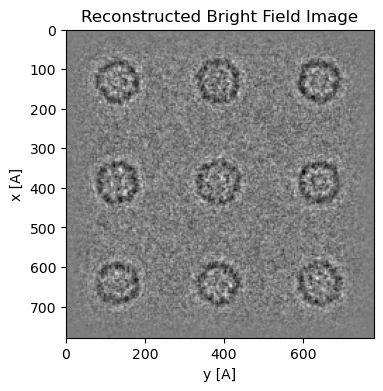

In [24]:
parallax = parallax.visualize(
    upsampled=True,
    figsize=(4,4),
    cmap='grey',
)

This means that if we want to process the dataset further, e.g. in single-particle analysis software like cryosparc or Relion, we need to correct its contrast transfer function (CTF).  
To do this, we first need to estimate the CTF by fitting the probe aberrations.

### Aberration Fitting
The cross-correlation vector field is proportial to the gradient of the aberration surface, so we can use them to fit aberration coefficients!

Rotation of Q w.r.t. R = -14.787 deg
Astigmatism (A1x,A1y)  = (72,352) Ang
Aberration C1          =  -14861 Ang
Defocus dF             = 14861 Ang
Transpose              = False


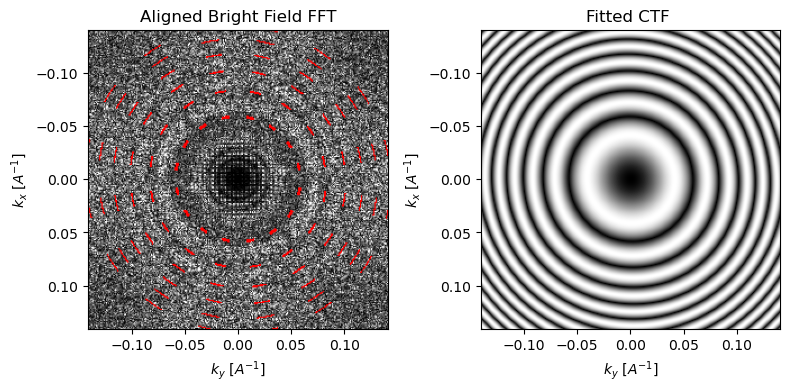

In [7]:
parallax = parallax.aberration_fit(
    plot_CTF_comparison=True,
)

The first thing the algorithm does is deconvolve the cross-correlation shifts to a rotational and a scaling component, using a polar decomposition.
The scaling component is then used to fit the aberration coefficients.

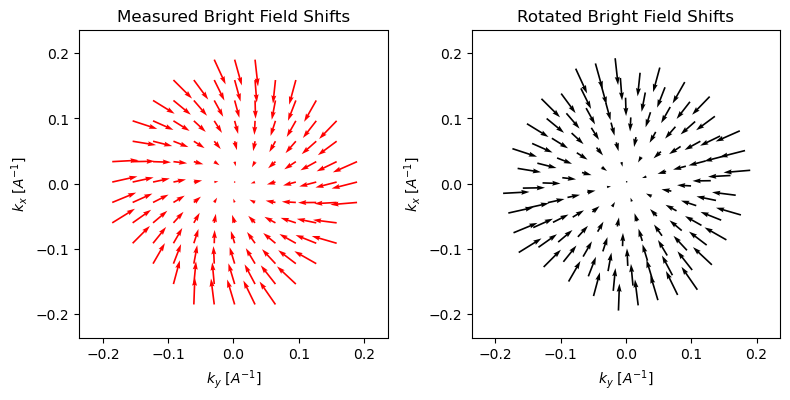

In [8]:
parallax.show_shifts(
    plot_arrow_freq=4, # plot every 4th arrow for clarity
)

If we invoke `show_shifts` again, then we obtain a visual representation of the two effects. The plot on the right is properly rotated, such that the shifts are radially outwards. And indeed, even with our very noisy dataset, the algorithm does fairly well at estimating both the rotation (measured: -18.3°, actual: -15°) and the defocus (measured: 1.517um, actual: 1.5um).

In [9]:
parallax.aberration_dict_polar

{'C10': -14860.88957582125,
 'C12': 359.7700650702563,
 'phi12': 0.6842515038789723,
 'C21': 0.0,
 'phi21': 0.0,
 'C23': 0.0,
 'phi23': 0.0}

### Higher-order Aberration Fitting
The default behavior of `aberration_fit` above resulted in estimates for defocus and astigmatism.
There are two additional methods to fit higher-order aberrations:
- Linear least squares fitting of the aberration surface gradient
- Nonlinear "Thon rings" fitting

The first method, builds an aberrations coefficents basis up a specified radial and angular order, and then fits their gradients against the calculated cross-correlation shifts. In this case, since we only simulated with defocus, higher-order don't contribute much to the fit.

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = -14.787 deg
Astigmatism (A1x,A1y)  = (72,352) Ang
Aberration C1          =  -14861 Ang
Defocus dF             = 14861 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -14842
C3              4        0         -      -2505266
stig            2        2         x      81
stig            2        2         y      359
coma            3        1         x      -105669
coma            3        1         y      -35678
trefoil         3        3         x      70
trefoil         3        3         y      230
stig2           4        2         x      -1244316
stig2           4        2         y      -887588


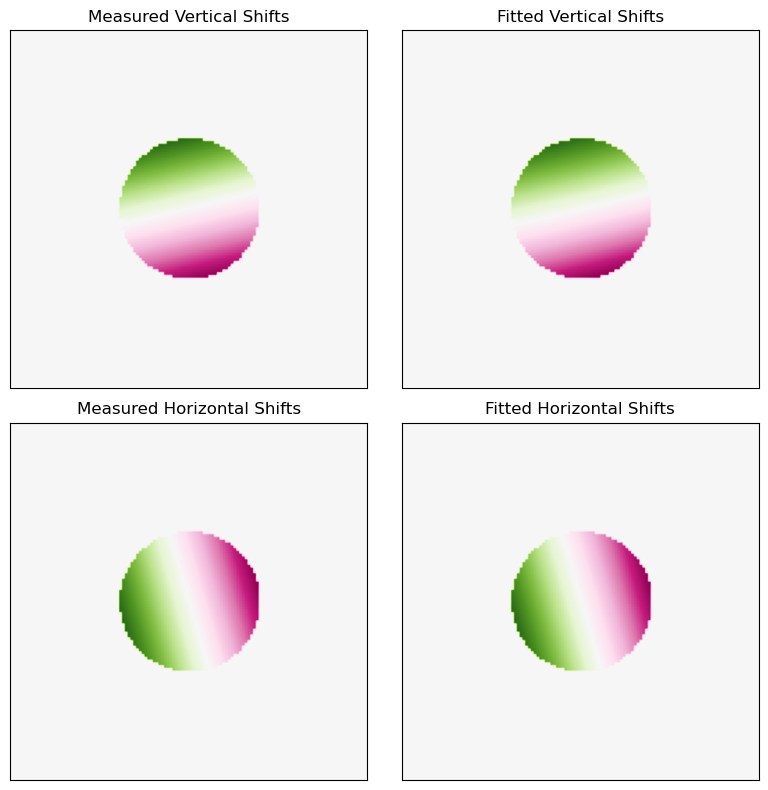

In [11]:
parallax = parallax.aberration_fit(
    fit_BF_shifts=True,
    fit_aberrations_max_radial_order=4,
    fit_aberrations_max_angular_order=3,
    plot_BF_shifts_comparison=True,
)

The second method fits the intensity modulations in the FFT directly, using an aberattion coefficients basis!

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = -14.787 deg
Astigmatism (A1x,A1y)  = (72,352) Ang
Aberration C1          =  -14861 Ang
Defocus dF             = 14861 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -15094
C3              4        0         -      0
stig            2        2         x      -154
stig            2        2         y      354
coma            3        1         x      0
coma            3        1         y      0
trefoil         3        3         x      1
trefoil         3        3         y      0
stig2           4        2         x      0
stig2           4        2         y      0


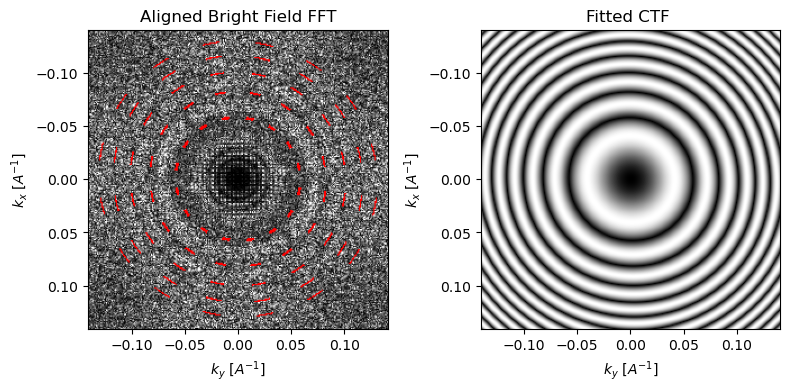

In [12]:
parallax = parallax.aberration_fit(
    fit_CTF_FFT=True,
    fit_max_thon_rings=5,
    fit_aberrations_max_radial_order=4,
    fit_aberrations_max_angular_order=3,
    plot_CTF_comparison=True,
)

### Aberration Correction

We can now use the fitted CTF to correct our reconstruction by "phase-flipping" the negative portions of the CTF.
This will lead to "dark-field" like contrast - as dictated be scattering physics.

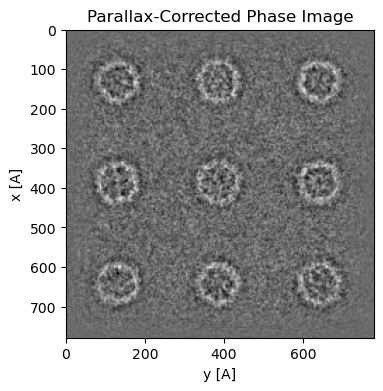

In [27]:
parallax = parallax.aberration_correct(
    figsize=(4,4),
    cmap='grey'
)

### Saving Reconstruction

It is often convenient to save your reconstructions, e.g. to share with collaborators or restart a calculation later.  
This can be achieved using the `py4DSTEM.save/read` functions

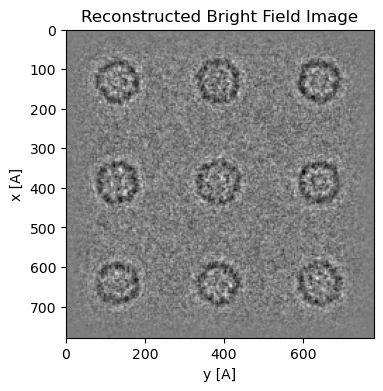

In [33]:
py4DSTEM.save(file_path+'parallax_apoferritin_recon.h5',parallax,mode='o')

new_parallax = py4DSTEM.read(file_path+'parallax_apoferritin_recon.h5')
new_parallax = new_parallax.visualize(
    upsampled=True,
    figsize=(4,4),
    cmap='grey',
)